In [60]:
from dotenv import load_dotenv
load_dotenv()

True

In [61]:
from langchain_groq import ChatGroq

# for type hinting
from typing import TypedDict, Literal, Annotated, Optional, List
import operator
from pydantic import BaseModel,Field
from langchain_core.output_parsers import PydanticOutputParser

In [62]:
def use_groq(prompt,model_name="openai/gpt-oss-20b",temperature=1):
    """
    Use the Groq model to generate a response to the prompt
    Args:
        prompt: The prompt to generate a response to
        model_name: The name of the model to use
        temperature: The temperature of the model
    Returns:
        The response from the model
    """
    llm = ChatGroq(
        model=model_name,  
        temperature=temperature
    )

    response = llm.invoke(prompt)
    return response.content

In [63]:
class DietPlanGenerationSchema(TypedDict):
      # -------- Core Profile (6) --------
    age: int
    gender: Literal["male", "female", "other"]
    height_cm: float
    weight_kg: float
    activity_level: Literal[
        "sedentary", "light", "moderate", "active"
    ]
    goal: Literal[
        "weight_loss", "weight_gain", "maintenance", "muscle_gain"
    ]

    # -------- Diet & Health (4) --------
    diet_type: Literal[
        "vegetarian", "vegan", "eggetarian", "non_vegetarian"
    ]
    allergies: Optional[List[str]]
    food_avoid: Optional[List[str]]
    health_conditions: Optional[List[Literal[
        "diabetes", "thyroid", "pcos", "hypertension"
    ]]]

    # -------- Lifestyle (2) --------
    region: Optional[str]
    workout_type: Optional[Literal[
        "none", "cardio", "strength", "mixed"
    ]]

    # -------- Plan Control (1) --------
    plan_duration_days: Literal[1, 7, 30]  # default = 7

    # -------- Agentic / Iteration Metadata --------
    diet_plan: str 
    feedback: Optional[str]
    evaluation_decision: Literal["approved", "not_approved"]

    iteration: int
    max_iteration: int

    feedback_list: Annotated[List[str], operator.add]
    plan_history: Annotated[List[str], operator.add]

In [64]:
class EvaluateSchema(BaseModel): 
    decision:Literal["approved","not_approved"]=Field(description="give the decision wheather the generated diet plan is approved or not.")
    feedback:str|None=Field(description="Give the feedback on generated diet plan if not written very well.")

evaluator_parser=PydanticOutputParser(pydantic_object=EvaluateSchema)


In [65]:
from langchain_core.prompts import ChatPromptTemplate


diet_plan_generator_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """
You are a certified nutritionist AI.

Your task is to generate a personalized diet plan based on user inputs.
Follow medical-safe guidelines. Do NOT give extreme calorie deficits or unsafe advice.

Rules:
- If plan_duration_days is missing, assume 7 days
- If health_conditions exist, strictly adjust food choices
- Infer missing preferences intelligently
- Use foods commonly available in the user's region
- Ensure variety across days
- Keep meals simple and realistic
- Avoid foods listed in allergies or food_avoid
- Adjust protein higher for muscle_gain or strength workouts
- Calories must align with goal and activity level

Output requirements:
- Clearly structured
- Day-wise plan
- Meal-wise breakdown
- Include approximate calories per day
- Include a short disclaimer at the end
"""
    ),
    (
        "human",
        """
User Profile:
Age: {age}
Gender: {gender}
Height (cm): {height_cm}
Weight (kg): {weight_kg}
Activity Level: {activity_level}
Goal: {goal}

Dietary Preferences:
Diet Type: {diet_type}
Allergies: {allergies}
Foods to Avoid: {food_avoid}

Health & Lifestyle:
Health Conditions: {health_conditions}
Region: {region}
Workout Type: {workout_type}

Plan Duration (days): {plan_duration_days}

Generate the diet plan now.
"""
    )
])


In [66]:
diet_plan_evaluator_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """
You are a diet plan quality evaluator AI.

Your task is to evaluate the generated diet plan against the user profile.

Evaluation Criteria:
1. Matches user's goal (weight loss/gain/maintenance/muscle gain)
2. Respects health conditions and allergies
3. Calorie level is safe and realistic
4. Meals are practical and region-appropriate
5. No extreme or unsafe recommendations

Decision Rules:
- If all criteria are satisfied → approved
- If any major issue exists → not_approved

"""
    ),
    (
        "human",
        """
User Profile:
Age: {age}
Gender: {gender}
Height (cm): {height_cm}
Weight (kg): {weight_kg}
Activity Level: {activity_level}
Goal: {goal}

Dietary Preferences:
Diet Type: {diet_type}
Allergies: {allergies}
Foods to Avoid: {food_avoid}

Health & Lifestyle:
Health Conditions: {health_conditions}
Region: {region}
Workout Type: {workout_type}

Plan Duration (days): {plan_duration_days}

Generated Diet Plan:
{diet_plan}

Evaluate the plan now.

format instruction : {format_instruction}
"""
    )
]).partial(format_instruction=evaluator_parser.get_format_instructions())


In [67]:


diet_plan_optimizer_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """
You are a diet plan optimization AI.

Your task is to improve an existing diet plan using evaluator feedback.
Do NOT regenerate from scratch unless explicitly required.

Optimization Rules:
- Fix only the issues mentioned in the feedback
- Preserve meals that are already suitable
- Maintain calorie alignment with the user's goal
- Respect health conditions, allergies, and diet type
- Keep food items region-appropriate
- Ensure the plan remains practical and simple
- Avoid drastic or extreme dietary changes
- Maintain meal variety across days

If feedback mentions:
- Calories too high/low → adjust portions, not food quality
- Health conflict → replace unsafe items with safer alternatives
- Repetition → swap equivalent meals
- Impractical meals → simplify ingredients

Output Requirements:
- Return the FULL updated diet plan
- Clearly structured day-wise and meal-wise
- Include updated daily calorie estimate
- Do not include explanations outside the plan
"""
    ),
    (
        "human",
        """
User Profile:
Age: {age}
Gender: {gender}
Height (cm): {height_cm}
Weight (kg): {weight_kg}
Activity Level: {activity_level}
Goal: {goal}

Dietary Preferences:
Diet Type: {diet_type}
Allergies: {allergies}
Foods to Avoid: {food_avoid}

Health & Lifestyle:
Health Conditions: {health_conditions}
Region: {region}
Workout Type: {workout_type}

Plan Duration (days): {plan_duration_days}

Previous Diet Plan:
{previous_diet_plan}

Evaluator Feedback:
{feedback}

Optimize the diet plan now.
"""
    )
])


In [68]:
def generate_diet_plan(state: DietPlanGenerationSchema):
    final_prompt=diet_plan_generator_prompt.format(age=state["age"],gender=state["age"],height_cm=state["height_cm"],weight_kg=state["weight_kg"],activity_level=state["activity_level"],goal=state["goal"],diet_type=state["diet_type"],allergies=state["allergies"],food_avoid=state["food_avoid"],health_conditions=state["health_conditions"],region=state["region"],workout_type=state["workout_type"],plan_duration_days=state["plan_duration_days"])
    response=use_groq(final_prompt)
    return {"diet_plan":response,"iteration":1,"feedback_list":[response]}

In [69]:
def evaluator_node(state: DietPlanGenerationSchema):
    final_prompt=diet_plan_evaluator_prompt.format(age=state["age"],gender=state["age"],height_cm=state["height_cm"],weight_kg=state["weight_kg"],activity_level=state["activity_level"],goal=state["goal"],diet_type=state["diet_type"],allergies=state["allergies"],food_avoid=state["food_avoid"],health_conditions=state["health_conditions"],region=state["region"],workout_type=state["workout_type"],plan_duration_days=state["plan_duration_days"],diet_plan=state["diet_plan"])
    response=use_groq(final_prompt)
    parsed_response=evaluator_parser.parse(response)

    return {"evaluation_decision":parsed_response.decision,"feedback":parsed_response.feedback,"feedback_list":[parsed_response.feedback]}

In [70]:
def optimizer_node(state:DietPlanGenerationSchema):
    final_prompt=diet_plan_optimizer_prompt.format(age=state["age"],gender=state["age"],height_cm=state["height_cm"],weight_kg=state["weight_kg"],activity_level=state["activity_level"],goal=state["goal"],diet_type=state["diet_type"],allergies=state["allergies"],food_avoid=state["food_avoid"],health_conditions=state["health_conditions"],region=state["region"],workout_type=state["workout_type"],plan_duration_days=state["plan_duration_days"],diet_plan=state["diet_plan"],feedback=state["feedback"])
    response=use_groq(final_prompt)
    iteration=state["iteration"]+1
    return {"tweet":response,"iteration":iteration,"tweet_list":[response]}

In [71]:
def condition_logic(state: DietPlanGenerationSchema)-> Literal["approved","not_approved"]:
    if state["evaluation_decision"]=="approved" or state["iteration"]>=state["max_iteration"]:
        return "approved"
    return "not_approved"

In [72]:
from langgraph.graph import END,START, StateGraph
graph=StateGraph(DietPlanGenerationSchema)

graph.add_node("generate_diet_plan",generate_diet_plan)
graph.add_node("evaluator_node",evaluator_node)
graph.add_node("optimizer_node",optimizer_node)

graph.add_edge(START,"generate_diet_plan")
graph.add_edge("generate_diet_plan","evaluator_node")
graph.add_conditional_edges("evaluator_node",condition_logic,{"approved":END,"not_approved":"optimizer_node"})
graph.add_edge("optimizer_node","evaluator_node")




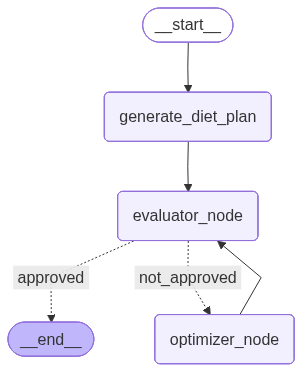

In [73]:
workflow=graph.compile()
workflow

In [74]:
initial_state={
  "age": 24,
  "gender": "male",
  "height_cm": 173,
  "weight_kg": 72,
  "activity_level": "moderate",
  "goal": "weight_loss",

  "diet_type": "vegetarian",
  "allergies": ["peanuts"],
  "food_avoid": ["deep fried food"],

  "health_conditions": ["diabetes"],
  "region": "India",
  "workout_type": "mixed",

  "plan_duration_days": 7,

  "iteration": 1,
  "max_iteration": 3,

  "feedback_list": [],
  "plan_history": []
}


In [75]:
final_state=workflow.invoke(initial_state)

In [78]:
print(final_state["diet_plan"])

**7‑Day Vegetarian Diabetes‑Friendly Weight‑Loss Diet Plan**  
*(Region: India – moderate activity, goal: gradual weight loss; approximate total calories ≈ 2,100 kcal/day)*  

| Day | Meal | Food Items (portion) | Approx. calories |
|-----|------|----------------------|------------------|
| **1** | Breakfast | Overnight oats (½ cup rolled oats + 1 cup skim milk + ½ cup berries + 1 tsp chia seeds) | 400 |
| | Snack | Greek‑style yogurt (1 cup) with 10 g almonds, drizzle honey | 300 |
| | Lunch | Brown‑rice pulao (½ cup cooked rice + ½ cup mixed veg + ¼ cup tofu) + 1 cup mixed dal | 600 |
| | Post‑workout | 1 scoop plant‑based protein (30 g) mixed in water | 120 |
| | Dinner | 2 whole‑wheat chapatis + 1 cup mixed veg curry (no oil) + ½ cup paneer (cottage cheese) | 600 |
| | Total | | **2,120** |
| **2** | Breakfast | Whole‑grain toast (2 slices) + 2 eggs (boiled) + ½ cup sautéed spinach | 400 |
| | Snack | Apple (1 medium) + 5 g walnuts | 200 |
| | Lunch | Quinoa salad (½ cup quinoa + ½